# 40.302 Advanced Optimization Project
Coherent walkthrough of the data preparation and portfolio optimization phases.


**Dependencies:** `numpy`, `pandas`, `matplotlib`, `cvxpy`, `scikit-learn`. Install optional solvers like `scs` or `osqp` for faster `cvxpy` solves.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from pathlib import Path
import re
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf

plt.style.use('seaborn-v0_8-darkgrid')


## Phase 1 — Censored Regression
Prepare censored regression targets, bounds, and synthetic extensions for downstream modeling.


In [2]:
# ====================== PARAMS ======================
input_path   = "financial_data_sp500_extended_synth_return_censored_bounds_FIXED.csv"
output_path  = "financial_data_sp500_extended_synth_return_censored_bounds.csv"


TARGET_END_DATE = "2025-12-31"

# Censoring (applied AFTER extension across all rows, including future rows)
EXTRA_HOLES       = 600          # or set to None to use rate
EXTRA_HOLE_RATE   = 0.15         # used only if EXTRA_HOLES is None
RNG_SEED          = 42

LOCK_FIRST_N_COLS = 3            # never blank these leading columns (often Date/Firm/Ticker)

# Synthetic data generation controls (for future rows)
HISTORY_LOOKBACK_Q   = 8         # look back up to last 8 quarters per company & column
NOISE_SCALE_FRACTION = 0.15      # base noise = NOISE_SCALE_FRACTION * |median|
MIN_NOISE_ABS        = 1.0       # add small absolute noise so zeros don't freeze
CLIP_TO_SIGN         = True      # keep sign consistent with company history for each column

# Optional overrides (set exact names if auto-detect fails)
COMPANY_KEY_COL   = None         # e.g., "Ticker"
GROSS_PROFIT_COL  = None         # e.g., "Gross Profit"
OPER_EXP_COL      = None         # e.g., "Total Operating Expenses"
DATE_COL          = None         # e.g., "Period End" or "Date"

# Bounds mode: "global" (all original history) or "trailing" (window up to hole date)
BOUNDS_MODE       = "global"
TRAILING_YEARS    = 2            # used only if BOUNDS_MODE == "trailing"

# Treat as numeric-like if >=70% parseable as numbers in the ORIGINAL data (for synthesis/predictor fills)
NUMERIC_LIKE_THRESHOLD = 0.7

# Division guard for return
EPS = 1e-9
# ====================================================


# ---------- load ----------
df_orig = pd.read_csv(input_path)
df = df_orig.copy()

def norm_map(dframe):
    return {c: str(c).strip().lower() for c in dframe.columns}

norm_df       = norm_map(df)
norm_df_orig  = norm_map(df_orig)

def pick_col(dframe, norm, preferred_exact_then_contains):
    # exact match first
    for target in preferred_exact_then_contains:
        for col in dframe.columns:
            if norm[col] == target:
                return col
    # then substring match
    for target in preferred_exact_then_contains:
        for col in dframe.columns:
            if target in norm[col]:
                return col
    return None

# ---------- detect key columns ----------
if COMPANY_KEY_COL is None:
    COMPANY_KEY_COL = pick_col(df, norm_df, ["ticker","symbol","company","company name","firm name","name"]) or df.columns[1]
if GROSS_PROFIT_COL is None:
    GROSS_PROFIT_COL = pick_col(df, norm_df, [
        "gross profit", "gross_profit", "grossprofit", "gross profit (loss)", "gross income"
    ])
if OPER_EXP_COL is None:
    OPER_EXP_COL = pick_col(df, norm_df, [
        "total operating expense", "total operating expenses",
        "operating expense", "operating expenses",
        "total operating cost and expenses", "total operating costs and expenses"
    ])
if DATE_COL is None:
    DATE_COL = pick_col(df, norm_df, ["period end", "report date", "date", "period", "fiscal period"])

if any(x is None for x in [COMPANY_KEY_COL, GROSS_PROFIT_COL, OPER_EXP_COL]):
    raise ValueError(
        "Could not auto-detect one or more required columns.\n"
        f"Detected -> company: {COMPANY_KEY_COL}, gross_profit: {GROSS_PROFIT_COL}, opex: {OPER_EXP_COL}, date: {DATE_COL}\n"
        f"Columns available: {list(df.columns)}"
    )

# ---------- lock ID/descriptor columns (never touched) ----------
lock_names = {
    "firm name", "company", "company name", "name",
    "ticker", "symbol", "cusip", "gvkey",
    "date", "period", "fiscal period", "period end", "report date",
    "quarter", "qtr", "fiscal quarter", "fiscal_qtr",
    "year", "fiscal year", "fiscal_year", "month"
}
id_cols_by_name = [c for c in df.columns if norm_df[c] in lock_names or any(k in norm_df[c] for k in
                    ["company","name","ticker","symbol","cusip","gvkey","date","period","quarter","qtr","fiscal","year","month"])]
id_cols_by_pos  = df.columns[:LOCK_FIRST_N_COLS].tolist()
ID_COLS = list(dict.fromkeys(id_cols_by_pos + id_cols_by_name))  # preserve order, dedup

# ---------- date parsing ----------
def to_dt(dframe, date_col, norm):
    if date_col is not None and date_col in dframe.columns:
        return pd.to_datetime(dframe[date_col], errors="coerce")
    # fallback: build from year+quarter if present
    year_col = None
    qtr_col  = None
    for c in dframe.columns:
        lc = norm[c]
        if "year" in lc: year_col = c
        if "quarter" in lc or lc.endswith("qtr"): qtr_col = c
    if year_col is not None and qtr_col is not None:
        q_end = {1:"-03-31",2:"-06-30",3:"-09-30",4:"-12-31"}
        return pd.to_datetime(dframe[year_col].astype(str) + dframe[qtr_col].astype(int).map(q_end), errors="coerce")
    return pd.NaT

df_orig["_dt"] = to_dt(df_orig, DATE_COL, norm_df_orig)
df["_dt"]      = to_dt(df, DATE_COL, norm_df)

target_end = pd.Timestamp(TARGET_END_DATE)
rng = np.random.default_rng(RNG_SEED)

# ---------- detect numeric-like value columns using ORIGINAL data (for synthesis & fills) ----------
def is_numeric_like_in_orig(col_name: str) -> bool:
    if col_name in ID_COLS or col_name == "_dt":
        return False
    parsed = pd.to_numeric(df_orig[col_name], errors="coerce")
    return parsed.notna().mean() >= NUMERIC_LIKE_THRESHOLD

VALUE_COLS = [c for c in df_orig.columns if is_numeric_like_in_orig(c)]

# ---------- helper: synthesize a value near company history ----------
def synth_value(hist_vals: pd.Series) -> float:
    h = pd.to_numeric(hist_vals, errors="coerce").dropna()
    if h.empty:
        base = 0.0
        scale = MIN_NOISE_ABS
        return float(base + rng.normal(0, scale))
    h = h.tail(HISTORY_LOOKBACK_Q)
    base = float(np.nanmedian(h))
    iqr  = float(np.nanpercentile(h, 75) - np.nanpercentile(h, 25)) if len(h) >= 4 else 0.0
    scale_hist = float(np.nanstd(h)) if len(h) >= 3 else 0.0
    scale = max(abs(base) * NOISE_SCALE_FRACTION, iqr * 0.2, scale_hist * 0.5, MIN_NOISE_ABS)
    val = base + rng.normal(0, scale)
    if CLIP_TO_SIGN:
        if (h >= 0).all():
            val = max(val, 0.0)
        if (h <= 0).all():
            val = min(val, 0.0)
    return float(val)

# ---------- extend to Dec-2025 (quarter-ends) & synthesize numeric values ----------
new_rows = []
for co, g in df_orig.groupby(COMPANY_KEY_COL, dropna=False):
    g = g.copy()
    last = pd.to_datetime(g["_dt"], errors="coerce").max()
    if pd.isna(last) or last >= target_end:
        continue
    # quarter-end series anchored to Dec (Mar/Jun/Sep/Dec)
    start = (last + pd.offsets.QuarterEnd()).normalize()
    q_dates = pd.date_range(start, target_end, freq="QE-DEC")
    if len(q_dates) == 0:
        continue

    # base template for IDs (take first non-null per ID col)
    id_template = {}
    for c in ID_COLS:
        if c == DATE_COL:
            continue
        lc = norm_df_orig.get(c, str(c).strip().lower())
        if ("year" in lc) or ("quarter" in lc) or lc.endswith("qtr"):
            id_template[c] = None  # will set from date
        else:
            id_template[c] = g[c].dropna().iloc[0] if (c in g.columns and g[c].notna().any()) else np.nan

    # company history subset for synthesis
    g_hist = df_orig[df_orig[COMPANY_KEY_COL] == co]

    for d in q_dates:
        row = {col: np.nan for col in df_orig.columns}
        # set date/period
        if DATE_COL is not None and DATE_COL in df_orig.columns:
            row[DATE_COL] = d.date()
        # derived year/quarter if columns exist
        for c in df_orig.columns:
            lc = norm_df_orig.get(c, str(c).strip().lower())
            if "year" in lc:
                row[c] = d.year
            if "quarter" in lc or lc.endswith("qtr"):
                row[c] = int(((d.month - 1) // 3) + 1)
        # set other IDs
        for c, v in id_template.items():
            if c in row and v is not None:
                row[c] = v
        # synthesize numeric-like value columns based on company history column-wise
        for col in VALUE_COLS:
            row[col] = synth_value(g_hist[col])
        row["_dt"] = d
        new_rows.append(row)

# append extension
if new_rows:
    df_extend = pd.DataFrame(new_rows)
    if "_dt" not in df_extend.columns:
        df_extend["_dt"] = pd.to_datetime(df_extend[DATE_COL], errors="coerce") if DATE_COL else pd.NaT
    cols_order = list(df_orig.columns)
    if "_dt" not in cols_order:
        cols_order.append("_dt")
    df_extend = df_extend.reindex(columns=cols_order)
    df = pd.concat([df, df_extend], ignore_index=True)

# keep company rows together, sorted by date
df["_dt"] = to_dt(df, DATE_COL, norm_df)
df["_dt_sort"] = df["_dt"].fillna(pd.Timestamp.max)
df = df.sort_values([COMPANY_KEY_COL, "_dt_sort"]).drop(columns=["_dt_sort"])

# ================= FIXED PREDICTOR FILL BLOCK =================
# all numeric-like predictors; do not include 'return'
PREDICTOR_COLS = [c for c in VALUE_COLS if c != "return"]

if len(PREDICTOR_COLS) > 0:
    # Ensure numeric
    df[PREDICTOR_COLS] = df[PREDICTOR_COLS].apply(pd.to_numeric, errors="coerce")

    # Treat zeros as missing for predictors
    df[PREDICTOR_COLS] = df[PREDICTOR_COLS].mask(df[PREDICTOR_COLS] == 0, np.nan)

    # 1) forward-fill within each company (row above)
    df[PREDICTOR_COLS] = (
        df.groupby(COMPANY_KEY_COL, dropna=False)[PREDICTOR_COLS]
          .apply(lambda g: g.ffill())
          .reset_index(level=0, drop=True)
    )

    # 2) fill remaining NaNs with THAT COMPANY'S MEDIAN computed from the ORIGINAL data
    orig_num = df_orig[PREDICTOR_COLS].apply(pd.to_numeric, errors="coerce")
    company_medians = orig_num.groupby(df_orig[COMPANY_KEY_COL]).median()

    for col in PREDICTOR_COLS:
        df[col] = df[col].fillna(df[COMPANY_KEY_COL].map(company_medians[col]))

    # 3) final safety: any stragglers -> 0
    df[PREDICTOR_COLS] = df[PREDICTOR_COLS].fillna(0.0)
# ==============================================================

# ---------------------------------------------
# compute 'return' for ALL rows (predictors set)
# ---------------------------------------------
gp  = pd.to_numeric(df[GROSS_PROFIT_COL], errors="coerce")
ope = pd.to_numeric(df[OPER_EXP_COL], errors="coerce")
den = ope.replace(0, np.nan)
ret = gp / den
ret[(den.abs() < EPS) | den.isna()] = np.nan
df["return"] = ret

# ---------------------------------------------
# censor ONLY the 'return' column (random rows)
# ---------------------------------------------
df["is_hole"] = False
candidate_idx = df.index.to_numpy()
if EXTRA_HOLES is None:
    EXTRA_HOLES = int(len(df) * EXTRA_HOLE_RATE)
EXTRA_HOLES = min(EXTRA_HOLES, len(candidate_idx))

hole_idx = np.array([], dtype=int)
if EXTRA_HOLES > 0:
    hole_idx = np.sort(rng.choice(candidate_idx, size=EXTRA_HOLES, replace=False))

df.loc[hole_idx, "is_hole"] = True
df.loc[hole_idx, "return"] = np.nan  # ONLY the target is censored; predictors remain intact

# ---------------------------------------------
# bounds from ORIGINAL data (pre-extension only)
# ---------------------------------------------
gp0  = pd.to_numeric(df_orig[GROSS_PROFIT_COL], errors="coerce")
ope0 = pd.to_numeric(df_orig[OPER_EXP_COL], errors="coerce")
den0 = ope0.replace(0, np.nan)
ret0 = gp0 / den0
ret0[(den0.abs() < EPS) | den0.isna()] = np.nan
df_orig["return_orig"] = ret0

# Prepare dates if trailing mode
if BOUNDS_MODE == "trailing":
    df_orig["_dt"] = to_dt(df_orig, DATE_COL, norm_df_orig)
    df["_dt"]      = to_dt(df, DATE_COL, norm_df)

df["lower_bound"] = np.nan
df["upper_bound"] = np.nan
mask_hole = df["is_hole"].astype(bool)

if BOUNDS_MODE == "global":
    min_dict = df_orig.groupby(COMPANY_KEY_COL)["return_orig"].min().to_dict()
    max_dict = df_orig.groupby(COMPANY_KEY_COL)["return_orig"].max().to_dict()
    df.loc[mask_hole, "lower_bound"] = df.loc[mask_hole, COMPANY_KEY_COL].map(min_dict).values
    df.loc[mask_hole, "upper_bound"] = df.loc[mask_hole, COMPANY_KEY_COL].map(max_dict).values

elif BOUNDS_MODE == "trailing":
    def trailing_bounds_for_row(row):
        co = row[COMPANY_KEY_COL]
        t  = row[DATE_COL] if (DATE_COL in row and pd.notna(row[DATE_COL])) else np.nan
        g  = df_orig[(df_orig[COMPANY_KEY_COL] == co) & df_orig["return_orig"].notna()].copy()
        if pd.notna(t):
            t  = pd.to_datetime(t, errors="coerce")
            start = t - pd.DateOffset(years=TRAILING_YEARS)
            g = g[(g["_dt"] > start) & (g["_dt"] <= t)]
        if g.empty:
            g = df_orig[(df_orig[COMPANY_KEY_COL] == co) & df_orig["return_orig"].notna()]
        if g.empty:
            return pd.Series({"lower_bound": np.nan, "upper_bound": np.nan})
        return pd.Series({
            "lower_bound": float(np.nanmin(g["return_orig"])),
            "upper_bound": float(np.nanmax(g["return_orig"]))
        })
    bounds = df.loc[mask_hole].apply(trailing_bounds_for_row, axis=1)
    df.loc[mask_hole, ["lower_bound", "upper_bound"]] = bounds.values
else:
    raise ValueError("Invalid BOUNDS_MODE. Use 'global' or 'trailing'.")

# ---------- final sort & save ----------
df["_dt"] = to_dt(df, DATE_COL, norm_df)
df["_dt_sort"] = df["_dt"].fillna(pd.Timestamp.max)
df = df.sort_values([COMPANY_KEY_COL, "_dt_sort"]).drop(columns=["_dt_sort"])
df.to_csv(output_path, index=False)

print("DONE")
print("----")
print(f"Extended to: {TARGET_END_DATE}")
print(f"Company key: {COMPANY_KEY_COL}")
print(f"Gross profit col: {GROSS_PROFIT_COL} | Opex col: {OPER_EXP_COL} | Date col: {DATE_COL}")
print(f"Total rows after extension: {len(df)}")
print(f"Return-censored rows: {int(mask_hole.sum())}")
print(f"Bounds mode: {BOUNDS_MODE} | Trailing years: {TRAILING_YEARS if BOUNDS_MODE=='trailing' else 'n/a'}")
print(f"Saved -> {output_path}")


DONE
----
Extended to: 2025-12-31
Company key: Ticker
Gross profit col: Gross Profit | Opex col: Total Operating Expenses | Date col: date
Total rows after extension: 8306
Return-censored rows: 600
Bounds mode: global | Trailing years: n/a
Saved -> financial_data_sp500_extended_synth_return_censored_bounds.csv


/var/folders/w0/ncph6pt923s4z1bh5py5104r0000gn/T/ipykernel_37122/4040195244.py:228: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill())


In [3]:
# ========= CONFIG =========
INPUT_PATH  = input_path
OUTPUT_PATH = output_path
COMPANY_KEY_COL = None    # e.g., "Ticker" (optional, improves per-company filling)
DATE_COL        = None    # e.g., "Period End" (optional, improves time interpolation)
PREDICTOR_OVERRIDE = None
# Treat |value| < EPS as zero
EPS = 1e-9
# Rolling window for local structure if needed
ROLL_WINDOW = 4
RNG_SEED = 42
# =========================

rng = np.random.default_rng(RNG_SEED)

df = pd.read_csv(INPUT_PATH)

# Normalize names
norm = {c: c.strip().lower() for c in df.columns}

# Non-predictors we always ignore
NON_PREDICTOR_DEFAULTS = {
    "return", "lower_bound", "upper_bound", "is_hole",
    "hole", "bound_lower", "bound_upper"
}

# ID-ish hints to exclude from predictors
ID_HINTS = {"company","company name","firm name","name","ticker","symbol","cusip","gvkey",
            "date","period","fiscal period","period end","report date",
            "quarter","qtr","fiscal quarter","fiscal_qtr","year","fiscal year","fiscal_year","month"}

# R&D exclusion helper
def is_research_dev(col_name: str) -> bool:
    s = norm.get(col_name, str(col_name).strip().lower())
    if "r&d" in s or "r and d" in s: return True
    if "research" in s and ("development" in s or "dev" in s): return True
    compact = re.sub(r"[^a-z0-9]+", "", s)
    return compact in {"researchdevelopment", "randd", "rd"}

# Choose predictors
if PREDICTOR_OVERRIDE:
    predictors = [c for c in PREDICTOR_OVERRIDE if c in df.columns and not is_research_dev(c)]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    predictors = []
    for c in numeric_cols:
        lc = norm.get(c, c.lower())
        if lc in NON_PREDICTOR_DEFAULTS: 
            continue
        if any(h in lc for h in ID_HINTS): 
            continue
        if is_research_dev(c):
            continue
        predictors.append(c)

if not predictors:
    raise ValueError("No predictor columns found after exclusions. Set PREDICTOR_OVERRIDE if needed.")

# Sort within company by date (if available) to make interpolation temporal
if DATE_COL and DATE_COL in df.columns:
    dt = pd.to_datetime(df[DATE_COL], errors="coerce")
    df["_dt_sort"] = dt
else:
    df["_dt_sort"] = np.arange(len(df))  # preserve original order if no date

if COMPANY_KEY_COL and COMPANY_KEY_COL in df.columns:
    df = df.sort_values([COMPANY_KEY_COL, "_dt_sort"]).reset_index(drop=True)
else:
    df = df.sort_values(["_dt_sort"]).reset_index(drop=True)

# Coerce predictors to numeric
df[predictors] = df[predictors].apply(pd.to_numeric, errors="coerce")

# Build failure masks BEFORE fixing (for logging)
pred_df = df[predictors]
fail_mask_initial = pred_df.isna() | (pred_df.abs() < EPS) | np.isinf(pred_df)
fails_initial = int(fail_mask_initial.any(axis=1).sum())
print(f"Initial rows with ANY predictor issue: {fails_initial} / {len(df)}")

# Global medians (ignore zeros and infs)
def safe_median(s):
    s = pd.to_numeric(s, errors="coerce")
    s[(~np.isfinite(s)) | (s.abs() < EPS)] = np.nan
    return np.nanmedian(s.values)

global_medians = {col: safe_median(df[col]) for col in predictors}

# Company medians (ignore zeros and infs), if company col provided
company_medians = None
if COMPANY_KEY_COL and COMPANY_KEY_COL in df.columns:
    # compute per company per column medians
    company_medians = {}
    for col in predictors:
        s = pd.to_numeric(df[col], errors="coerce")
        s[(~np.isfinite(s)) | (s.abs() < EPS)] = np.nan
        company_medians[col] = df.groupby(COMPANY_KEY_COL)[col].median()

# Repair function per column within each company (or globally if no company col)
def repair_series(s: pd.Series) -> pd.Series:
    # Step 0: treat zeros/inf as NaN
    x = s.copy().astype(float)
    x[(~np.isfinite(x)) | (x.abs() < EPS)] = np.nan

    # Step 1: local rolling median (helps if there are short gaps)
    x = x.fillna(x.rolling(ROLL_WINDOW, min_periods=1, center=True).median())

    # Step 2: linear interpolate (both directions)
    x = x.interpolate(method="linear", limit_direction="both")

    # Step 3: ffill/bfill as safety
    x = x.ffill().bfill()

    return x

# Apply repair
if COMPANY_KEY_COL and COMPANY_KEY_COL in df.columns:
    # repair per company for temporal consistency
    for col in predictors:
        df[col] = (
            df.groupby(COMPANY_KEY_COL, dropna=False)[col]
              .apply(repair_series)
              .reset_index(level=0, drop=True)
        )
        # company-level median fill for any stragglers
        if company_medians is not None:
            med_map = company_medians[col]
            df[col] = df[col].fillna(df[COMPANY_KEY_COL].map(med_map))
        # global median fallback
        if np.isnan(global_medians[col]):
            # if even global median is NaN, fallback small noise around 0
            df[col] = df[col].fillna(rng.normal(0.0, 1.0, size=len(df)))
        else:
            df[col] = df[col].fillna(global_medians[col])
        # final tiny noise nudge for values still ~0 after fills
        zero_idx = df[col].abs() < EPS
        if zero_idx.any():
            scale = max(abs(global_medians[col]) * 0.01, 1.0)
            df.loc[zero_idx, col] = global_medians[col] + rng.normal(0.0, scale, size=zero_idx.sum())
else:
    # no company key – repair globally preserving overall order
    for col in predictors:
        df[col] = repair_series(df[col])
        if np.isnan(global_medians[col]):
            df[col] = df[col].fillna(rng.normal(0.0, 1.0, size=len(df)))
        else:
            df[col] = df[col].fillna(global_medians[col])
        zero_idx = df[col].abs() < EPS
        if zero_idx.any():
            scale = max(abs(global_medians[col]) * 0.01, 1.0)
            df.loc[zero_idx, col] = global_medians[col] + rng.normal(0.0, scale, size=zero_idx.sum())

# Re-check
pred_df2 = df[predictors].apply(pd.to_numeric, errors="coerce")
fails_after = int((pred_df2.isna() | (pred_df2.abs() < EPS) | np.isinf(pred_df2)).any(axis=1).sum())
print(f"After repair, rows with ANY predictor issue: {fails_after} / {len(df)}")

# Save
df = df.drop(columns=["_dt_sort"], errors="ignore")
df.to_csv(OUTPUT_PATH, index=False)
print(f"✅ Saved repaired file -> {OUTPUT_PATH}")



Initial rows with ANY predictor issue: 0 / 8306
After repair, rows with ANY predictor issue: 0 / 8306
✅ Saved repaired file -> financial_data_sp500_extended_synth_return_censored_bounds.csv


In [4]:
# ==== CONFIG ====
INPUT_CSV   = "financial_data_sp500_extended_synth_return_censored_bounds.csv"
OUTPUT_CSV  = "financial_data_sp500_convex_imputed.csv"
USE_HUBER      = True      # else plain least squares (QP)
HUBER_M        = 1.35
RIDGE_L2       = 1e-3      # 0 disables
USE_SOFT_LOWER = True      # True = soft (hinge penalty); False = hard inequality
LOWER_WEIGHT   = 50.0      # weight for soft lower bound penalty

EXCLUDE_COLS = {
    "return","lower_bound","upper_bound","is_hole",
    "tobit_cutoff","predicted_latent_return","imputed_return_tobit",
}
ID_HINTS = ("company","firm","name","ticker","symbol","cusip","gvkey",
            "date","period","fiscal","quarter","qtr","year","month","_dt")

def is_rd(col: str) -> bool:
    s = col.strip().lower()
    return ("r&d" in s) or ("r and d" in s) or ("research" in s and ("development" in s or "dev" in s)) \
           or "".join(ch for ch in s if ch.isalnum()) in {"researchdevelopment","randd","rd"}

# ==== LOAD ====
df = pd.read_csv(INPUT_CSV)

# target and masks
y = pd.to_numeric(df["return"], errors="coerce")
obs_mask  = y.notna()
hole_mask = y.isna()

# bounds (we'll only use lower bound)
lo = pd.to_numeric(df.get("lower_bound"), errors="coerce")

# ==== BUILD X ====
num_cols = df.select_dtypes(include=[np.number]).columns
pred_cols = []
for c in num_cols:
    lc = c.strip().lower()
    if c in EXCLUDE_COLS:               continue
    if any(h in lc for h in ID_HINTS):  continue
    if is_rd(c):                        continue
    pred_cols.append(c)
if not pred_cols:
    raise ValueError("No predictors found after exclusions; pick a manual list.")

X = df[pred_cols].astype(float).values

# scale for numerical stability
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

# split
X_obs  = X_scaled[obs_mask]
y_obs  = y[obs_mask].to_numpy()
X_hole = X_scaled[hole_mask]
lo_h   = lo[hole_mask].to_numpy() if lo is not None else None

# ==== VARIABLE (with intercept) ====
p = X_scaled.shape[1]
X_scaled = np.hstack([np.ones((X_scaled.shape[0],1)), X_scaled])
X_obs    = np.hstack([np.ones((X_obs.shape[0],1)),    X_obs])
X_hole   = np.hstack([np.ones((X_hole.shape[0],1)),   X_hole])
beta     = cp.Variable(p+1)

# ==== OBJECTIVE on observed ====
resid = X_obs @ beta - y_obs
if USE_HUBER:
    data_loss = cp.sum(cp.huber(resid, M=HUBER_M))
else:
    data_loss = cp.sum_squares(resid)
reg = RIDGE_L2 * cp.sum_squares(beta[1:]) if RIDGE_L2 > 0 else 0.0

constraints = []
bound_pen = 0.0

# ==== ONE-SIDED LOWER BOUND ON HOLES ====
if X_hole.size > 0 and lo_h is not None:
    preds_h = X_hole @ beta
    m = ~np.isnan(lo_h)
    if m.any():
        idx = np.nonzero(m)[0]
        if USE_SOFT_LOWER:
            # soft: hinge penalty on (lo - pred)+
            bound_pen += LOWER_WEIGHT * cp.sum(cp.pos(lo_h[idx] - preds_h[idx]))
        else:
            # hard: pred >= lo
            constraints.append(preds_h[idx] >= lo_h[idx])

obj = cp.Minimize(data_loss + reg + bound_pen)
prob = cp.Problem(obj, constraints)

# ==== SOLVE (auto-pick) ====
installed = set(cp.installed_solvers())
if USE_HUBER:
    solver_order = ["ECOS", "SCS", "OSQP"]   # Huber -> ECOS/SCS
else:
    solver_order = ["OSQP", "ECOS", "SCS"]   # LS -> OSQP
used_solver, result = None, None
for s in solver_order:
    if s not in installed: 
        continue
    try:
        result = prob.solve(solver=s, verbose=False)
        if prob.status in ("optimal", "optimal_inaccurate") and beta.value is not None:
            used_solver = s
            break
    except Exception:
        pass
if used_solver is None:
    result = prob.solve(verbose=False)

print(f"Status: {prob.status} | Solver: {used_solver or prob.solver_stats.solver_name} | Obj: {result}")

# ==== PREDICT & IMPUTE ====
beta_vec = np.asarray(beta.value).reshape(-1)
y_hat = X_scaled @ beta_vec

# Safety clamp to lower bound where available (holes only)
if "lower_bound" in df.columns:
    has_lo = lo.notna()
    y_hat = np.where(has_lo & hole_mask, np.maximum(y_hat, lo.values), y_hat)

df["predicted_latent_return"] = y_hat
df["imputed_return_cvx"]      = np.where(obs_mask, y.values, y_hat)

df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved -> {OUTPUT_CSV}")
print(f"Predictors used ({len(pred_cols)}):", pred_cols[:10], "..." if len(pred_cols)>10 else "")



Status: optimal | Solver: ECOS | Obj: 2038.513319037138
Saved -> financial_data_sp500_convex_imputed.csv
Predictors used (14): ['Income Before Tax', 'Net Income', 'Selling General Administrative', 'Gross Profit', 'Ebit', 'Operating Income', 'Interest Expense', 'Income Tax Expense', 'Total Revenue', 'Total Operating Expenses'] ...


In [5]:
imputed = pd.read_csv("financial_data_sp500_convex_imputed.csv")
imputed[imputed['is_hole'] == True].head()

,Unnamed: 0,date,firm,Ticker,Research Development,Income Before Tax,Net Income,Selling General Administrative,Gross Profit,Ebit,...,Total Other Income Expense Net,Net Income From Continuing Ops,Net Income Applicable To Common Shares,_dt,return,is_hole,lower_bound,upper_bound,predicted_latent_return,imputed_return_cvx
42,120,9/30/2025,American Airlines Group,AAL,NaN,-1.539464e+09,-2.257811e+09,1.232533e+08,2.288418e+08,-2.489485e+09,...,9.618968e+08,-2.119517e+09,-1.397037e+09,2025-09-30,NaN,True,-0.361301,0.093612,0.471385,0.471385
53,40,12/31/2022,Advance Auto Parts,AAP,NaN,2.486543e+08,1.411142e+08,1.280215e+09,1.500456e+09,2.542310e+08,...,-1.000720e+07,1.501362e+08,1.594109e+08,2022-12-31,NaN,True,0.488693,8.449892,0.942151,0.942151
57,40,12/31/2023,Advance Auto Parts,AAP,NaN,3.001908e+08,2.495293e+08,1.001635e+09,8.966827e+08,2.519334e+08,...,-3.482073e+06,2.384477e+08,1.870156e+08,2023-12-31,NaN,True,0.488693,8.449892,0.791295,0.791295
58,40,3/31/2024,Advance Auto Parts,AAP,NaN,2.295363e+08,1.766597e+08,1.164888e+09,9.357679e+08,2.707555e+08,...,-6.712383e+06,1.585472e+08,1.871642e+08,2024-03-31,NaN,True,0.488693,8.449892,0.876629,0.876629
79,184,9/30/2023,Apple,AAPL,NaN,2.182502e+10,1.869872e+10,4.483476e+09,3.825606e+10,3.063515e+10,...,1.878758e+08,2.162611e+10,2.625796e+10,2023-09-30,NaN,True,0.361145,1.241792,1.358706,1.358706


## Phase 2 — Correlation & Covariance Matrix
Estimate and regularize the cross-sectional covariance matrix that feeds the optimizer.


Panel shape: (158, 502)
Correlation matrix shape: (502, 502)
Missing values in panel: 0

=== Top 25 Firms by Variance ===
firm
Advance Auto Parts           0.357142
Fortive                      0.137299
Moderna                      0.103124
Devon Energy                 0.054593
Mastercard                   0.050304
APA Corporation              0.047847
Capital One Financial        0.034297
Fleetcor                     0.031966
MSCI                         0.028092
Hologic                      0.027624
Gilead Sciences              0.025590
Northern Trust               0.025330
Moody's Corporation          0.023644
Fifth Third Bancorp          0.023387
Host Hotels & Resorts        0.023008
NortonLifeLock               0.022318
JPMorgan Chase               0.021839
Intuit                       0.021543
NRG Energy                   0.021295
Intercontinental Exchange    0.021037
First Republic Bank          0.020821
M&T Bank                     0.020742
Citizens Financial Group     0.019565

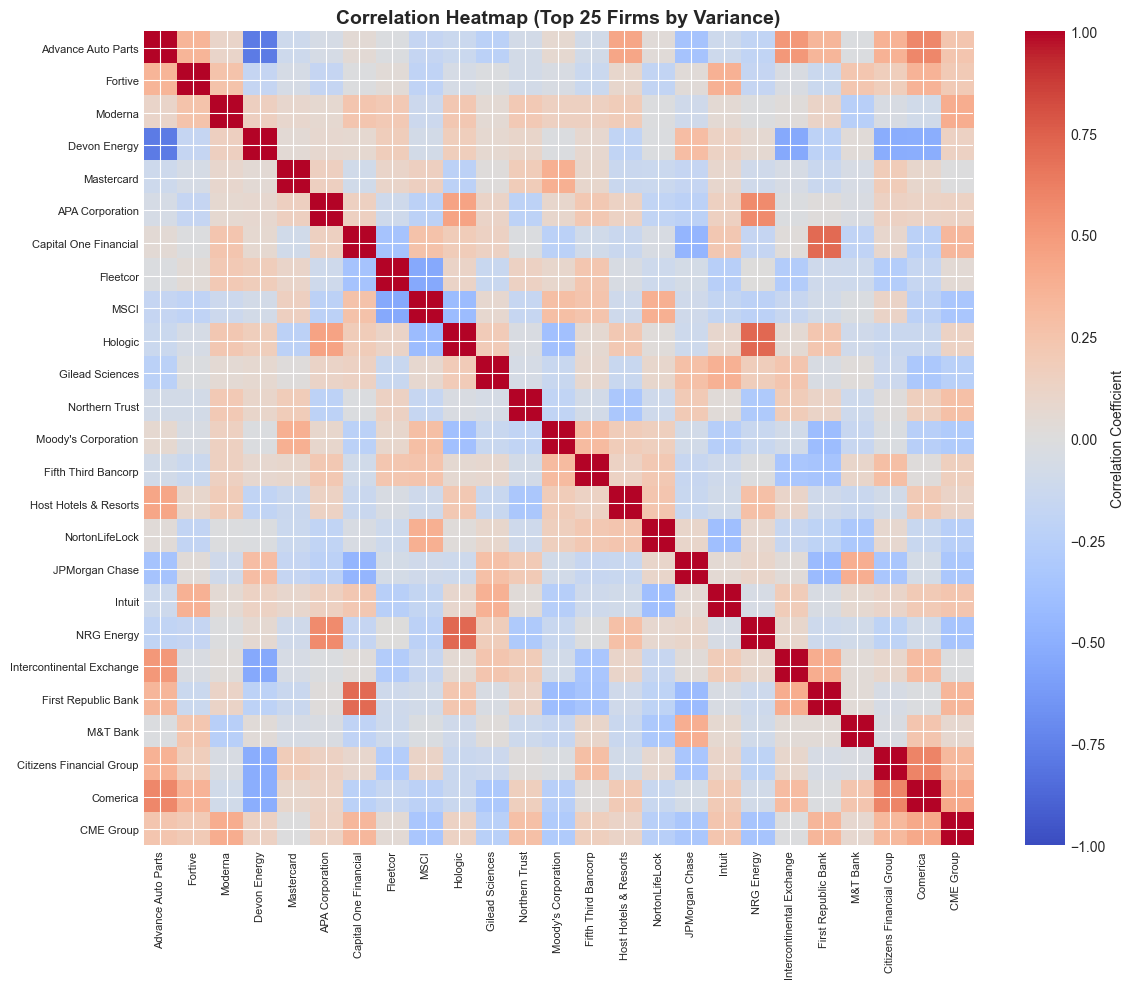


=== Top 20 Firms Most Correlated with 3M ===
firm
Ameriprise Financial         0.606021
Dollar Tree                  0.591305
Church & Dwight              0.549128
Alphabet (Class C)           0.523920
IQVIA                        0.517929
International Paper          0.499605
Everest Re                   0.497199
LKQ Corporation              0.493885
Edwards Lifesciences         0.481903
News Corp (Class A)          0.471946
Intercontinental Exchange    0.453700
JPMorgan Chase               0.439579
Huntington Bancshares        0.417374
LyondellBasell               0.413597
KLA Corporation             -0.452345
Lumen Technologies          -0.465850
Garmin                      -0.502226
Boston Scientific           -0.531821
Ceridian                    -0.553956
Conagra Brands              -0.578327
Name: 3M, dtype: float64


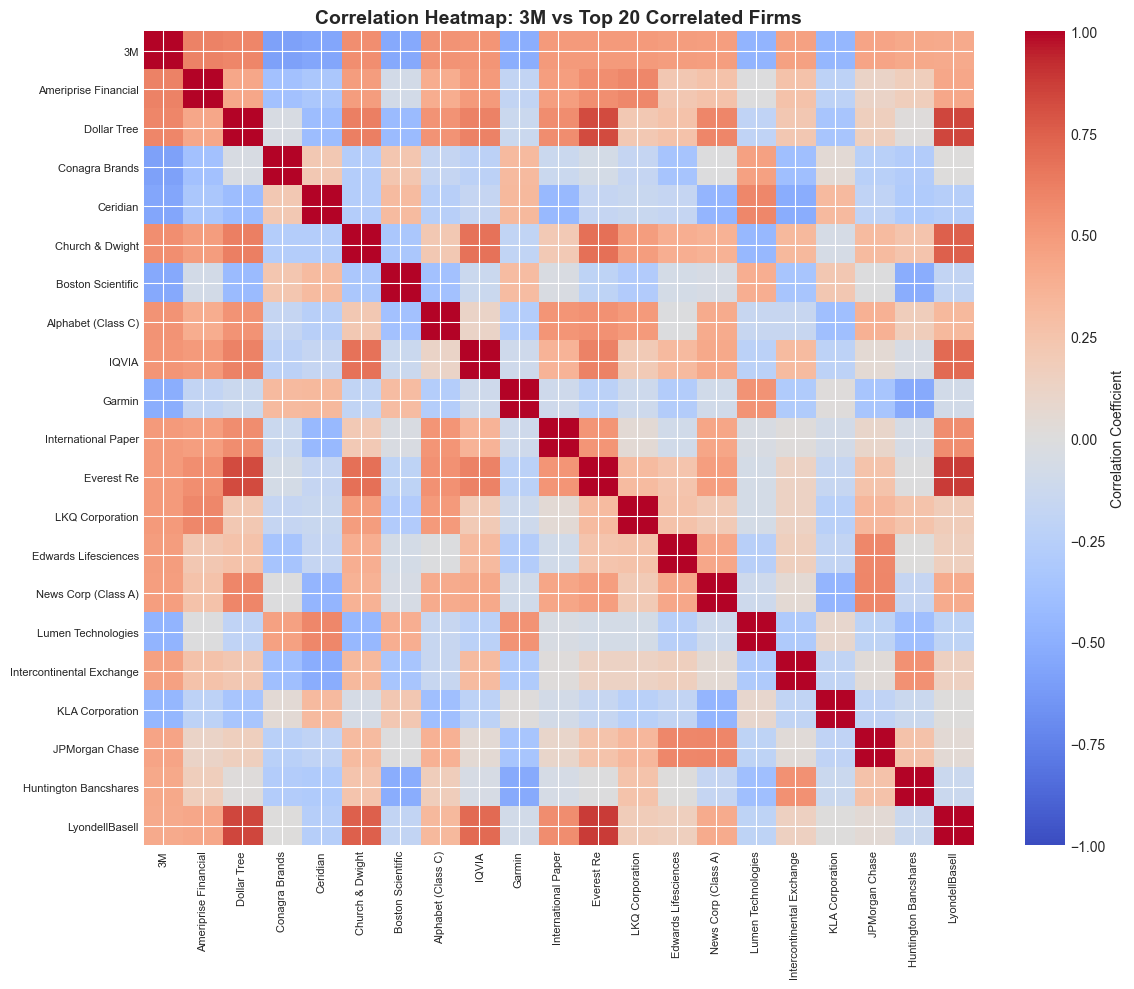


=== Strongest Positive Correlations with 3M ===
firm
Ameriprise Financial    0.606021
Dollar Tree             0.591305
Church & Dwight         0.549128
Alphabet (Class C)      0.523920
IQVIA                   0.517929
Name: 3M, dtype: float64

=== Strongest Negative Correlations with 3M ===
firm
Conagra Brands       -0.578327
Ceridian             -0.553956
Boston Scientific    -0.531821
Garmin               -0.502226
Lumen Technologies   -0.465850
Name: 3M, dtype: float64

=== Correlation Matrix Summary Statistics ===
Mean correlation: 0.0005
Median correlation: -0.0000
Std correlation: 0.1930
Max correlation: 0.9999
Min correlation: -0.9998

Most correlated pair: Realty Income Corporation <-> ServiceNow (0.9999)


In [6]:
# ===============================================
# Load & Prepare Panel with Proper Imputation
# ===============================================
file_path = "financial_data_sp500_convex_imputed.csv"
df = pd.read_csv(file_path)
val_col = "imputed_return_cvx"  # your imputed returns column

# Create panel: pivot to wide format (dates × firms)
panel = (df.pivot_table(index="date", columns="firm", values=val_col)
         .sort_index())

# Proper imputation: use mean imputation (Code 2 logic)
panel_imputed = panel.apply(lambda col: col.fillna(col.mean()), axis=0)

# ===============================================
# Compute Correlation Matrix
# ===============================================
corr = panel_imputed.corr()

print(f"Panel shape: {panel_imputed.shape}")
print(f"Correlation matrix shape: {corr.shape}")
print(f"Missing values in panel: {panel_imputed.isna().sum().sum()}")

# ===============================================
# Heatmap 1: Top-N firms by variance
# ===============================================
top_n = 25
firm_variances = panel_imputed.var().sort_values(ascending=False)
top_idx = firm_variances.nlargest(top_n).index

print(f"\n=== Top {top_n} Firms by Variance ===")
print(firm_variances.head(top_n))

corr_top = corr.loc[top_idx, top_idx]

plt.figure(figsize=(12, 10))
plt.imshow(corr_top.values, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(len(top_idx)), labels=top_idx, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(top_idx)), labels=top_idx, fontsize=8)
plt.title(f"Correlation Heatmap (Top {top_n} Firms by Variance)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===============================================
# Heatmap 2: Focus on a specific company X
# ===============================================
company_x = "3M"  # <-- change this to your target firm name

if company_x not in corr.columns:
    # Fallback: use firm with highest variance
    company_x = firm_variances.index[0]
    print(f"\nNote: 'Dominos Pizza' not found. Using '{company_x}' instead.")

if company_x is not None:
    k = 20
    
    # Get correlations with company_x (excluding itself)
    s = corr[company_x].drop(labels=[company_x])
    
    # Find top k firms by absolute correlation
    topk_idx = s.abs().nlargest(k).index.tolist()
    
    # Create subset: company_x + its top correlated firms
    sub_idx = [company_x] + topk_idx
    corr_x = corr.loc[sub_idx, sub_idx]
    
    print(f"\n=== Top {k} Firms Most Correlated with {company_x} ===")
    print(s.loc[topk_idx].sort_values(ascending=False))
    
    plt.figure(figsize=(12, 10))
    plt.imshow(corr_x.values, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient')
    plt.xticks(ticks=np.arange(len(sub_idx)), labels=sub_idx, rotation=90, fontsize=8)
    plt.yticks(ticks=np.arange(len(sub_idx)), labels=sub_idx, fontsize=8)
    plt.title(f"Correlation Heatmap: {company_x} vs Top {k} Correlated Firms", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: show strongest positive and negative correlations
    print(f"\n=== Strongest Positive Correlations with {company_x} ===")
    print(s.nlargest(5))
    
    print(f"\n=== Strongest Negative Correlations with {company_x} ===")
    print(s.nsmallest(5))
    
else:
    print("No suitable company found for the focused heatmap.")

# ===============================================
# Optional: Summary Statistics
# ===============================================
print("\n=== Correlation Matrix Summary Statistics ===")
# Get upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr), k=1).astype(bool)
upper_triangle = corr.where(mask)

print(f"Mean correlation: {upper_triangle.mean().mean():.4f}")
print(f"Median correlation: {upper_triangle.median().median():.4f}")
print(f"Std correlation: {upper_triangle.std().mean():.4f}")
print(f"Max correlation: {upper_triangle.max().max():.4f}")
print(f"Min correlation: {upper_triangle.min().min():.4f}")

# Find most correlated pair (excluding diagonal)
corr_no_diag = corr.copy()
np.fill_diagonal(corr_no_diag.values, np.nan)
max_corr_idx = np.unravel_index(np.nanargmax(corr_no_diag.values), corr_no_diag.shape)
firm1, firm2 = corr_no_diag.index[max_corr_idx[0]], corr_no_diag.columns[max_corr_idx[1]]
print(f"\nMost correlated pair: {firm1} <-> {firm2} ({corr_no_diag.iloc[max_corr_idx]:.4f})")

# ===============================================
# Optional: Export results
# ===============================================
# corr_top.to_csv("correlation_top_variance_firms.csv")
# corr_x.to_csv(f"correlation_{company_x}_focused.csv")

Raw full panel (T×n): (158, 502)
μ shape: (502,) | Σ_reg shape: (502, 502) | method: Ledoit–Wolf
Eigenvalue range: [4.260e-03, 8.156e-02]  → PD OK: True


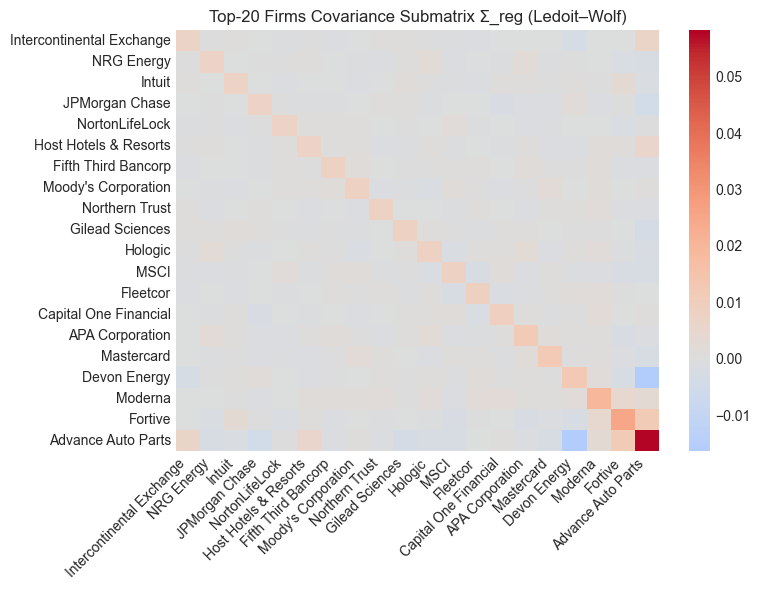

In [9]:
# ---- 1) Load only what's needed ----
df = pd.read_csv("financial_data_sp500_convex_imputed.csv",
                 usecols=["date", "firm", "imputed_return_cvx"]).rename(
    columns={"date": "Month", "firm": "Firm", "imputed_return_cvx": "Imputed_Return"}
)
df = df.dropna(subset=["Imputed_Return"]).copy()

# Make Month sortable (keep as-is if not parseable)
try:
    df["Month"] = pd.to_datetime(df["Month"])
except Exception:
    pass

# ---- 2) Ensure unique (Month, Firm) and pivot to raw panel ----
df_agg = (df.groupby(["Month", "Firm"], as_index=False)["Imputed_Return"]
            .mean()
            .sort_values(["Firm", "Month"]))

# Build FULL panel: include ALL months present in dataset and ALL firms
months_all = df_agg["Month"].sort_values().unique()
firms_all  = df_agg["Firm"].sort_values().unique()

panel = (df_agg.pivot(index="Month", columns="Firm", values="Imputed_Return")
                .reindex(index=months_all, columns=firms_all)   # keep full duration & all firms
                .sort_index())

T, n = panel.shape
print(f"Raw full panel (T×n): {panel.shape}")

# ---- 3) Impute missing values (keep everyone) ----
# Strategy: within-firm mean imputation; if an entire firm is NaN, fill with 0
# (You can switch to forward/backward fill per firm if you prefer.)
firm_means = panel.mean(axis=0, skipna=True)
panel_imputed = panel.apply(lambda col: col.fillna(col.mean()), axis=0)

# If any column remained NaN everywhere (rare), set to 0
all_nan_cols = panel_imputed.columns[panel_imputed.isna().all(axis=0)]
if len(all_nan_cols) > 0:
    panel_imputed[all_nan_cols] = 0.0

# Still-missing sporadic cells (if a firm mean was NaN) → fill 0 as last resort
panel_imputed = panel_imputed.fillna(0.0)

# ---- 4) μ and regularised Σ (Ledoit–Wolf preferred) ----
mu = panel_imputed.mean(axis=0).to_numpy(dtype=float)          # (n,)

# Center data for covariance
X = panel_imputed.to_numpy(dtype=float)
Xc = X - mu                                                    # broadcast mean subtraction

# Regularised covariance (works well when T << n)
try:
    Sigma_reg = LedoitWolf().fit(Xc).covariance_
    method = "Ledoit–Wolf"
except Exception:
    # Ridge shrinkage fallback
    Sigma_emp = np.cov(Xc, rowvar=False, ddof=1)
    alpha = 0.10
    tau = float(np.trace(Sigma_emp) / n)
    Sigma_reg = (1 - alpha) * Sigma_emp + alpha * tau * np.eye(n)
    method = f"ridge(alpha={alpha})"

# Numerical hygiene
Sigma_reg = 0.5 * (Sigma_reg + Sigma_reg.T)
Sigma_reg += 1e-8 * np.eye(n)

# ---- 5) Diagnostics ----
eig = np.linalg.eigvalsh(Sigma_reg)
print(f"μ shape: {mu.shape} | Σ_reg shape: {Sigma_reg.shape} | method: {method}")
print(f"Eigenvalue range: [{eig.min():.3e}, {eig.max():.3e}]  → PD OK: {eig.min() > 0}")

# ---- 6) Visualise covariance matrix ----
import matplotlib.pyplot as plt
import seaborn as sns

# Focus on the 20 firms with the highest variance
variances = np.diag(Sigma_reg)
top_idx = np.argsort(variances)[-20:]
top_firms = panel_imputed.columns[top_idx]

plt.figure(figsize=(8, 6))
sns.heatmap(Sigma_reg[np.ix_(top_idx, top_idx)],
            xticklabels=top_firms,
            yticklabels=top_firms,
            cmap="coolwarm", center=0)
plt.title(f"Top-20 Firms Covariance Submatrix Σ_reg ({method})")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# (Optional) persist for Phase 3
# panel_imputed.to_csv("phase2_panel_full.csv")
# pd.DataFrame({'Firm': panel_imputed.columns, 'mu': mu}).to_csv("phase2_mu_full.csv", index=False)
# pd.DataFrame(Sigma_reg, index=panel_imputed.columns, columns=panel_imputed.columns).to_csv("phase2_Sigma_full.csv")


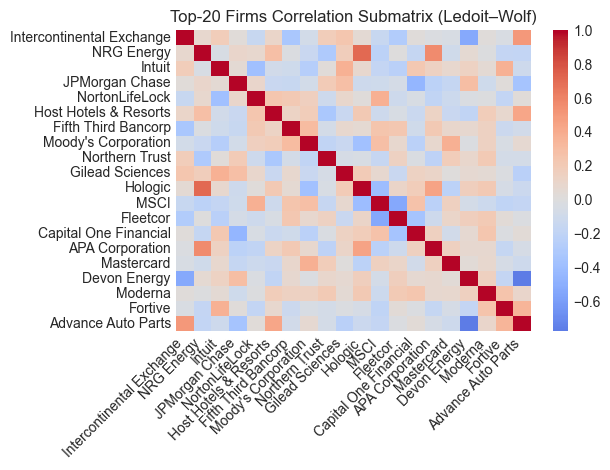

In [10]:
corr_reg = np.corrcoef(Xc, rowvar=False)
sns.heatmap(corr_reg[np.ix_(top_idx, top_idx)],
            xticklabels=top_firms,
            yticklabels=top_firms,
            cmap="coolwarm", center=0)
plt.title("Top-20 Firms Correlation Submatrix (Ledoit–Wolf)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Phase 3 — Markowitz Mean–Variance Portfolio
Construct the efficient frontier, highlight key portfolios, and visualize positioning.


Building efficient frontier...

=== Efficient Frontier Summary ===
      gamma  expected_return  risk_std  sharpe_ratio  HHI
0  0.001000         2.641409  0.065802      40.14169  1.0
1  0.001425         2.641409  0.065802      40.14169  1.0
2  0.002031         2.641409  0.065802      40.14169  1.0
3  0.002894         2.641409  0.065802      40.14169  1.0
4  0.004125         2.641409  0.065802      40.14169  1.0
5  0.005878         2.641409  0.065802      40.14169  1.0
6  0.008377         2.641409  0.065802      40.14169  1.0
7  0.011938         2.641409  0.065802      40.14169  1.0
8  0.017013         2.641409  0.065802      40.14169  1.0
9  0.024245         2.641409  0.065802      40.14169  1.0

TANGENCY PORTFOLIO (Max Sharpe) (γ = 1e+03)
Expected Return:      2.0882
Risk (Std Dev):       0.0175
Sharpe Ratio:         119.2373
Concentration (HHI):  0.0610 (≈ 1/16 equivalent firms)
Active Positions:     35/502

Top 15 Holdings:
  Visa                            13.17%
  Verisign        

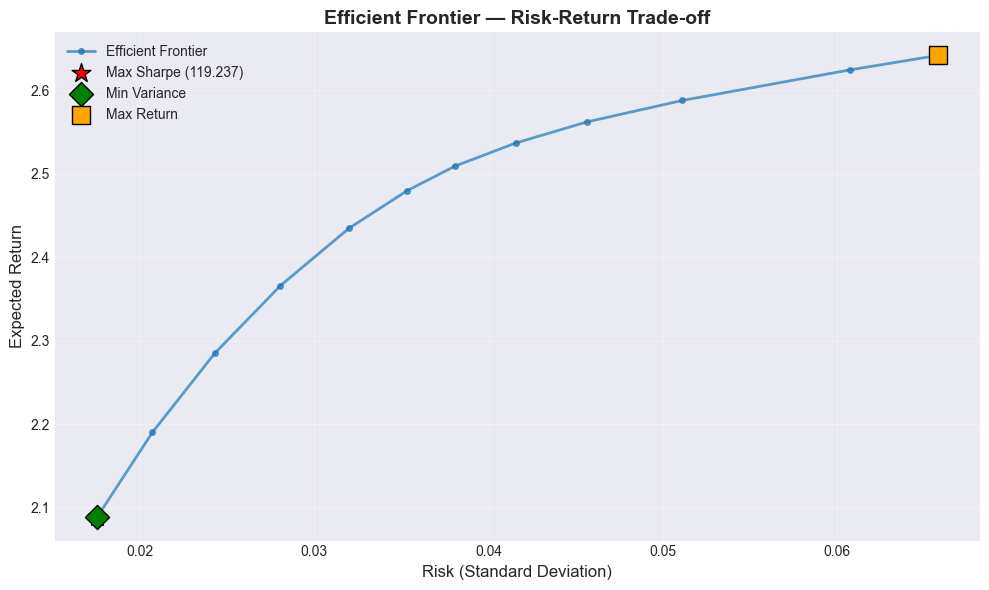

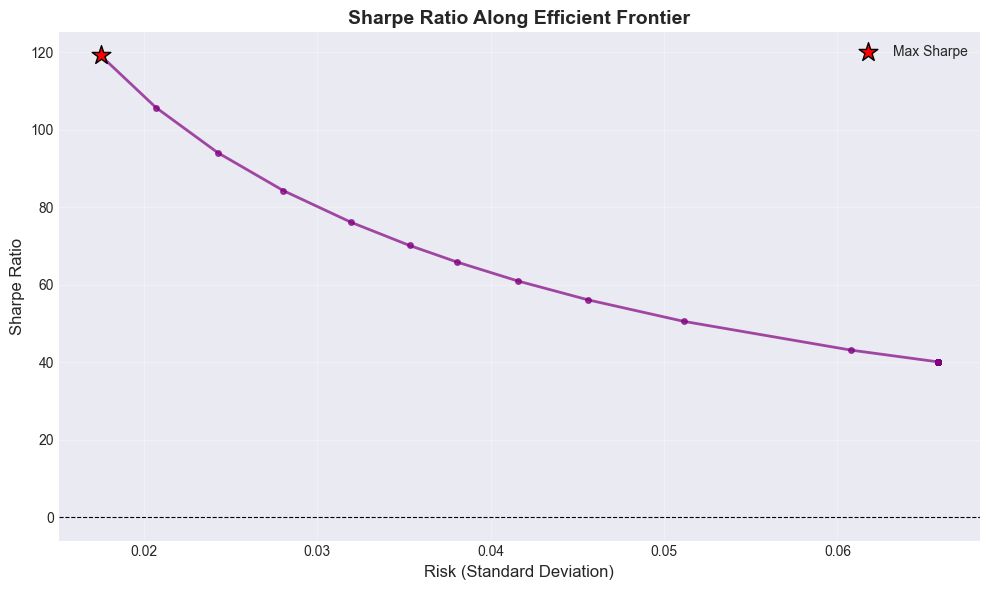

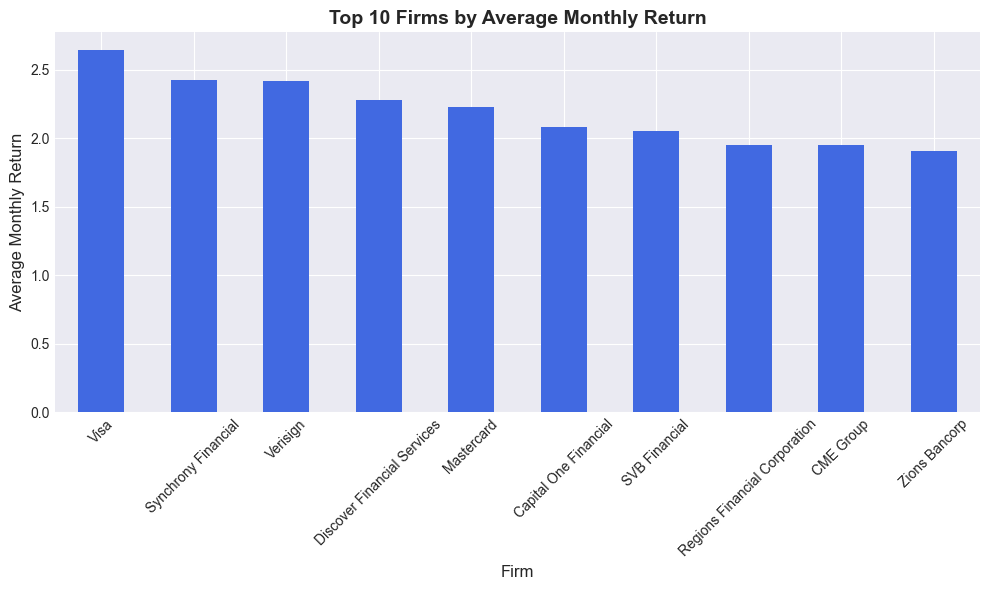

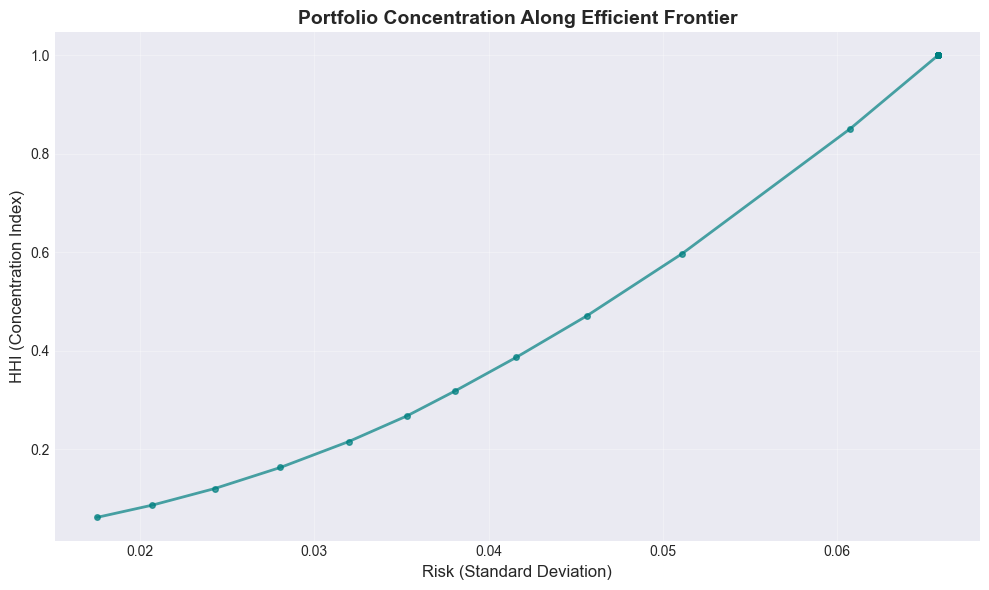


=== Analysis Complete ===
Generated 40 portfolios along the efficient frontier
Tangency portfolio Sharpe ratio: 119.2373


In [8]:
# ===============================================
# Prerequisites from Phase 2:
#   panel_imputed  (DataFrame T×n)
#   mu             (n,) — expected returns
#   Sigma_reg      (n,n) — regularized covariance (PD)
# ===============================================

firms = list(panel_imputed.columns)

# ===============================================
# Helper Functions
# ===============================================

def project_to_simplex(v: np.ndarray) -> np.ndarray:
    """Euclidean projection onto { w >= 0, sum w = 1 }."""
    v = np.asarray(v, float)
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0.0)

def solve_markowitz_pgd(mu, Sigma, gamma, iters=3000, step=None, tol=1e-9, w0=None, verbose=False):
    """
    Minimise:  f(w) = -mu^T w + gamma * w^T Sigma w
    s.t.       w >= 0, 1^T w = 1  (enforced by simplex projection)
    
    Parameters:
    -----------
    mu : array (n,)
        Expected returns
    Sigma : array (n,n)
        Covariance matrix (must be PSD)
    gamma : float
        Risk aversion parameter (higher = more risk-averse)
    iters : int
        Maximum iterations
    step : float or None
        Step size (auto-computed if None)
    tol : float
        Convergence tolerance
    w0 : array or None
        Initial weights
    verbose : bool
        Print convergence info
        
    Returns:
    --------
    w : array (n,)
        Optimal portfolio weights
    """
    mu = np.asarray(mu, float)
    Sigma = np.asarray(Sigma, float)
    n = mu.size
    w = np.ones(n) / n if w0 is None else project_to_simplex(w0)

    # Auto-compute step size based on Lipschitz constant
    if step is None:
        try:
            lam_max = max(np.linalg.eigvalsh(Sigma).max(), 1e-8)
            L = max(2.0 * gamma * lam_max, 1e-8)
            step = 1.0 / L
        except Exception:
            step = 0.05  # safe fallback

    last_obj = None
    for t in range(iters):
        grad = -mu + 2.0 * gamma * (Sigma @ w)
        w = project_to_simplex(w - step * grad)
        
        if (t + 1) % 50 == 0:
            obj = -mu @ w + gamma * (w @ Sigma @ w)
            if last_obj is not None and abs(obj - last_obj) < tol:
                if verbose:
                    print(f"Converged at iter {t+1}, obj {obj:.6g}")
                break
            last_obj = obj
    
    return w

# ===============================================
# Build Efficient Frontier
# ===============================================

print("Building efficient frontier...")
gammas = np.logspace(-3, 3, 40)  # Risk aversion: 1e-3 (aggressive) to 1e3 (conservative)
weights, rets, risks, sharpes = [], [], [], []

rf = 0.0  # Risk-free rate (adjust if needed)

for g in gammas:
    w = solve_markowitz_pgd(mu, Sigma_reg, gamma=g, iters=2500, step=None, tol=1e-9)
    weights.append(w)
    ret = mu @ w
    risk = np.sqrt(w @ Sigma_reg @ w)
    rets.append(ret)
    risks.append(risk)
    sharpes.append((ret - rf) / risk if risk > 0 else 0)

frontier = pd.DataFrame({
    "gamma": gammas,
    "expected_return": rets,
    "risk_std": risks,
    "sharpe_ratio": sharpes,
    "HHI": [(w**2).sum() for w in weights]  # Concentration index
})

print("\n=== Efficient Frontier Summary ===")
print(frontier.head(10))

# ===============================================
# Identify Key Portfolios
# ===============================================

idx_max_sharpe = np.argmax(sharpes)
idx_min_risk = np.argmin(risks)
idx_max_return = np.argmax(rets)

def show_portfolio_details(w, gamma_val, label=""):
    """Display detailed portfolio breakdown."""
    ret = mu @ w
    risk = np.sqrt(w @ Sigma_reg @ w)
    sharpe = (ret - rf) / risk if risk > 0 else 0
    hhi = (w**2).sum()
    n_active = (w > 0.001).sum()  # Positions > 0.1%
    
    print(f"\n{'='*60}")
    print(f"{label} (γ = {gamma_val:.3g})")
    print(f"{'='*60}")
    print(f"Expected Return:      {ret:.4f}")
    print(f"Risk (Std Dev):       {risk:.4f}")
    print(f"Sharpe Ratio:         {sharpe:.4f}")
    print(f"Concentration (HHI):  {hhi:.4f} (≈ 1/{int(1/hhi)} equivalent firms)")
    print(f"Active Positions:     {n_active}/{len(w)}")
    
    # Top holdings
    top_k = 15
    s = pd.Series(w, index=firms).sort_values(ascending=False).head(top_k)
    print(f"\nTop {top_k} Holdings:")
    for firm, weight in s.items():
        print(f"  {firm:30s} {weight:7.2%}")
    
    return ret, risk, sharpe

# Display key portfolios
ret_sharpe, risk_sharpe, sharpe_val = show_portfolio_details(
    weights[idx_max_sharpe],
    gammas[idx_max_sharpe],
    label="TANGENCY PORTFOLIO (Max Sharpe)"
)

ret_minvar, risk_minvar, _ = show_portfolio_details(
    weights[idx_min_risk],
    gammas[idx_min_risk],
    label="MINIMUM VARIANCE PORTFOLIO"
)

ret_maxret, risk_maxret, _ = show_portfolio_details(
    weights[idx_max_return],
    gammas[idx_max_return],
    label="MAXIMUM RETURN PORTFOLIO"
)

# ===============================================
# Top Firms Analysis
# ===============================================

print("\n\n=== Top Firms Analysis ===")

# Individual firm returns
mean_returns = panel_imputed.mean(axis=0)
mean_returns_sorted = mean_returns.sort_values(ascending=False)

print("\nTop 10 firms by average monthly return:")
print(mean_returns_sorted.head(10))

top_firm = mean_returns_sorted.idxmax()
top_value = mean_returns_sorted.max()
print(f"\nHighest individual return: {top_firm} ({top_value:.4f})")

# Average weight across frontier
weights_df = pd.DataFrame(weights, columns=firms)
print("\nTop 10 firms by average weight across efficient frontier:")
print(weights_df.mean().sort_values(ascending=False).head(10))

# ===============================================
# Visualizations
# ===============================================

# Plot 1: Efficient Frontier
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(risks, rets, 'o-', linewidth=2, markersize=4, alpha=0.7, label='Efficient Frontier')

# Highlight key portfolios
ax.scatter(risk_sharpe, ret_sharpe, s=200, c='red', marker='*',
           label=f'Max Sharpe ({sharpe_val:.3f})', zorder=5, edgecolors='black')
ax.scatter(risk_minvar, ret_minvar, s=150, c='green', marker='D',
           label='Min Variance', zorder=5, edgecolors='black')
ax.scatter(risk_maxret, ret_maxret, s=150, c='orange', marker='s',
           label='Max Return', zorder=5, edgecolors='black')

ax.set_title("Efficient Frontier — Risk-Return Trade-off", fontsize=14, fontweight='bold')
ax.set_xlabel("Risk (Standard Deviation)", fontsize=12)
ax.set_ylabel("Expected Return", fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Sharpe Ratio Evolution
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(risks, sharpes, 'o-', linewidth=2, markersize=4, color='purple', alpha=0.7)
ax.scatter(risk_sharpe, sharpe_val, s=200, c='red', marker='*',
           zorder=5, edgecolors='black', label='Max Sharpe')
ax.set_title("Sharpe Ratio Along Efficient Frontier", fontsize=14, fontweight='bold')
ax.set_xlabel("Risk (Standard Deviation)", fontsize=12)
ax.set_ylabel("Sharpe Ratio", fontsize=12)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Top Individual Firms
fig, ax = plt.subplots(figsize=(10, 6))
mean_returns_sorted.head(10).plot(kind='bar', ax=ax, color='royalblue')
ax.set_title("Top 10 Firms by Average Monthly Return", fontsize=14, fontweight='bold')
ax.set_ylabel("Average Monthly Return", fontsize=12)
ax.set_xlabel("Firm", fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Plot 4: Concentration Analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(risks, frontier['HHI'], 'o-', linewidth=2, markersize=4, color='teal', alpha=0.7)
ax.set_title("Portfolio Concentration Along Efficient Frontier", fontsize=14, fontweight='bold')
ax.set_xlabel("Risk (Standard Deviation)", fontsize=12)
ax.set_ylabel("HHI (Concentration Index)", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===============================================
# Optional: Export Results
# ===============================================
# frontier.to_csv("phase3_efficient_frontier.csv", index=False)
# weights_df.to_csv("phase3_portfolio_weights.csv", index=False)
# mean_returns_sorted.to_csv("phase3_individual_firm_returns.csv")

print("\n=== Analysis Complete ===")
print(f"Generated {len(gammas)} portfolios along the efficient frontier")
print(f"Tangency portfolio Sharpe ratio: {sharpe_val:.4f}")